In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os, json
from tqdm import tqdm
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image
from model_trainingtime_prediction.model_level_utils_cnn import convert_cnn2d_data, TimeHistory

In [2]:
from model_trainingtime_prediction.env_detect import gpu_features, general_features

gpu_features().get_features()

{'timestamp': '2021/10/06 12:25:44.462',
 'driver_version': '460.73.01',
 'count': '1',
 'name': 'Tesla P100-PCIE-16GB',
 'pcie.link.width.max': '16',
 'vbios_version': '86.00.52.00.02',
 'memory.total [MiB]': '16280 MiB',
 'temperature.gpu': '37'}

# CNN

## Data

In [ ]:
target_size = (128, 128, 3)
batch_size = 256


X_sample = np.ones((100, *target_size))
Y_sample = np.ones(100)

## 6. Construction of the first model (ConvNet)

CNNs are a specific type of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, that is, that pixels close to each other are often related.

The construction of a CNN begins with specifying the model type. In our case, we will use a ``Sequential`` model.

<p><img src = "https://i.ibb.co/0jWhFsW/ConvNet.png" alt></p>

In [ ]:
def Alex_model(compile_model=False):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
    #Instantiation
    AlexNet = Sequential()

    #1st Convolutional Layer
    AlexNet.add(Conv2D(filters=96, input_shape=target_size, kernel_size=(11,11), strides=(4,4), padding='same', activation='relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same', activation='relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, input_shape=(32,32,3,), activation='relu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.4))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096, activation='relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000, activation='relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #Output Layer
    AlexNet.add(Dense(1, activation='softmax'))
    
    if compile_model:
        AlexNet.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return AlexNet

    

In [ ]:
def CNN():
    CNN = Sequential()
    CNN.add(Conv2D(32, (3, 3), input_shape = target_size, activation = 'relu'))
    CNN.add(MaxPooling2D(pool_size = (2, 2)))
    CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
    CNN.add(MaxPooling2D(pool_size = (2, 2)))
    CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
    CNN.add(SpatialDropout2D(0.2))
    CNN.add(MaxPooling2D(pool_size = (2, 2)))
    CNN.add(Flatten())
    CNN.add(Dense(units = 128, activation = 'relu'))
    CNN.add(Dropout(0.2))
    CNN.add(Dense(units = 1, activation = 'sigmoid'))
    return CNN

# All layers are trainable

In [ ]:
model = Alex_model()

In [ ]:
# Callbacks

time_callback_trainable = TimeHistory()

# Compile
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train
model.fit(X_sample,Y_sample, batch_size = batch_size, epochs = 5, callbacks = [time_callback_trainable], verbose=False)


# Non-trainable

In [ ]:
model = Alex_model()
for layer in model.layers:
    layer.trainable = False

In [ ]:
# Callbacks

time_callback_non_trainable= TimeHistory()

# Compile
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train
model.fit(X_sample,Y_sample, batch_size = batch_size, epochs = 5, callbacks = [time_callback_non_trainable], verbose=False)


In [ ]:
np.mean(time_callback_trainable.batch_times[1:])

In [ ]:
np.mean(time_callback_non_trainable.batch_times[1:])

# Partially non-trainable

In [ ]:
x = []
y = []
top_n = len(model.layers)
for i in tqdm(range(top_n)):
    x.append(i)
    model = Alex_model()
    for layer in model.layers[:i]:
        layer.trainable = False
    # Callbacks

    time_callback_non_trainable= TimeHistory()

    # Compile
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    # Train
    model.fit(X_sample,Y_sample, batch_size = batch_size, epochs = 5, callbacks = [time_callback_non_trainable], verbose=False)
    y.append(np.mean(time_callback_non_trainable.batch_times[1:]))
    


In [ ]:
layey_names = [' '.join(i.name.split('_')[:-1]) for i in model.layers]
layey_names = ['all'] + layey_names
layey_names = layey_names[:top_n]

In [ ]:
plt.scatter(x, y)
plt.xticks(x, layey_names, rotation=90)
plt.show()

# Dense

In [ ]:
def build_dense_model(layer_sizes, activations):
    model_dense = Sequential()
    for index, size in enumerate(layer_sizes):
        model_dense.add(Dense(size, activation=activations[index]))
    return model_dense

In [ ]:
x_dense = np.ones((1000, 1000))
y_dense = np.ones((1000, 1000))

In [ ]:
layer_sizes = [1000]*100
activations = ['relu']*100
optimizer = 'adam'
loss = 'mae'
dense = build_dense_model(layer_sizes, activations)
dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [ ]:
time_callback_dense_trainable= TimeHistory()
dense.fit(x_dense,y_dense, batch_size = batch_size, epochs = 1, callbacks = [time_callback_dense_trainable], verbose=False)

In [ ]:
dense = build_dense_model(layer_sizes, activations)

for layer in dense.layers:
    layer.trainable = False
dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [ ]:
time_callback_dense_non_trainable= TimeHistory()
dense.fit(x_dense,y_dense, batch_size = batch_size, epochs = 1, callbacks = [time_callback_dense_non_trainable], verbose=False)

In [ ]:
np.mean(time_callback_dense_trainable.batch_times[1:])

In [ ]:
np.mean(time_callback_dense_non_trainable.batch_times[1:])

# partially

In [ ]:
x = []
y = []
top_n = len(dense.layers)
for i in tqdm(range(top_n)):
    x.append(i)
    dense = build_dense_model(layer_sizes, activations)
    for layer in dense.layers[:i]:
        layer.trainable = False
    # Callbacks

    time_callback_non_trainable= TimeHistory()

    # Compile
    dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # Train
    dense.fit(x_dense, y_dense, batch_size = batch_size, epochs = 1, callbacks = [time_callback_non_trainable], verbose=False)
    y.append(np.mean(time_callback_non_trainable.batch_times[1:]))
    
layey_names = [' '.join(i.name.split('_')[:-1]) for i in dense.layers]
layey_names = ['all'] + layey_names
layey_names = layey_names[:top_n]

In [ ]:
plt.figure(figsize=(20, 8))
plt.scatter(x, y)
plt.xticks(x, layey_names, rotation=90)
plt.show()

# Find relationship between trainable and non-trainale


In [ ]:
from model_trainingtime_prediction.model_level_utils import gen_nn, model_train_data, convert_dense_data

In [ ]:
gnn = gen_nn(
    hidden_layers_num_lower=50,
    hidden_layers_num_upper=51, # only up to 51, influence train feature1
    hidden_layer_size_lower=1,
    hidden_layer_size_upper=1001, # only up to 1001, max we want to take
    activation='random',
    optimizer='random', # random
    loss='random'
)
model_configs = gnn.generate_model_configs(num_model_data=1)


In [ ]:
def build_dense_model(layer_sizes, activations):
    model_dense = Sequential()
    for index, size in enumerate(layer_sizes):
        model_dense.add(Dense(size, activation=activations[index]))
    return model_dense

In [ ]:
batch_size = 128
epochs = 10


In [ ]:
all_training_times = []
trainable_list = []
model = build_dense_model(
                layer_sizes=model_configs[0]['layer_sizes'],
                activations=model_configs[0]['activations']
            )
input_shape = model.get_config()['layers'][0]['config']['units']
out_shape = model.get_config()['layers'][-1]['config']['units']
x = np.ones((batch_size, input_shape), dtype=np.float32)
y = np.ones((batch_size, out_shape), dtype=np.float32)

model.compile(loss=model_configs[0]['loss'], optimizer=model_configs[0]['optimizer'], metrics=['accuracy'])

time_callback = TimeHistory()
model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

all_training_times.append(np.mean(time_callback.batch_times[1:]))

for i in tqdm(range(len(model_configs[0]['layer_sizes']))):
    model = build_dense_model(
                layer_sizes=model_configs[0]['layer_sizes'],
                activations=model_configs[0]['activations']
            )
    input_shape = model.get_config()['layers'][0]['config']['units']
    out_shape = model.get_config()['layers'][-1]['config']['units']
    x = np.ones((batch_size, input_shape), dtype=np.float32)
    y = np.ones((batch_size, out_shape), dtype=np.float32)

    layer = model.layers[i]
    layer.trainable = False
    model_trainable_list = []
    for l in model.layers:
        model_trainable_list.append(l.trainable)
    trainable_list.append(model_trainable_list)
    model.compile(loss=model_configs[0]['loss'], optimizer=model_configs[0]['optimizer'], metrics=['accuracy'])

    time_callback = TimeHistory()
    model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)
    all_training_times.append(np.mean(time_callback.batch_times[1:]))


In [ ]:
len(convert_dense_data.get_flops_dense(x.shape[0], model, sum_all=False))

In [ ]:
plt.scatter(range(len(all_training_times)), all_training_times)

In [ ]:
plt.scatter(model_configs[0]['layer_sizes'], all_training_times[1:]) 

In [ ]:
plt.scatter(convert_dense_data.get_flops_dense(x.shape[0], model, sum_all=False), all_training_times[1:])

In [ ]:
plt.scatter(range(len(model_configs[0]['layer_sizes'])), model_configs[0]['layer_sizes'])

In [ ]:
plt.scatter(range(len(all_training_times)), all_training_times)

# Find relationship between trainable and non-trainale CNN

In [ ]:
from model_trainingtime_prediction.model_level_utils_cnn import gen_cnn2d, convert_cnn2d_data

In [ ]:
gen = gen_cnn2d(input_shape_lower=100,
        input_shape_upper=129,
        conv_layer_num_lower=50,
        conv_layer_num_upper=51,
        filter_lower=1,
        filter_upper=101,
        dense_layer_num_lower=1,
        dense_layer_num_upper=6,
        dense_size_lower=1,
        dense_size_upper=1001,
        max_pooling_prob=1,
        input_channels=None,
        paddings=None,
        activations=None,
        optimizers=None,
        losses=None)
model_configs = gen.generate_model_configs(num_model_data=1, progress=True)


In [ ]:
def build_cnn2d_model(kwargs_list, layer_orders):
      cnn2d = Sequential()
      for i, lo in enumerate(layer_orders):
          kwargs = kwargs_list[i]
          if lo == "Dense":
              cnn2d.add(Dense(**kwargs))
          elif lo == "Conv2D":
              cnn2d.add(Conv2D(**kwargs))
          elif lo == "MaxPooling2D":
              cnn2d.add(MaxPooling2D(**kwargs))
          elif lo == "Dropout":
              cnn2d.add(Dropout(**kwargs))
          elif lo == "Flatten":
              cnn2d.add(Flatten())
      kwargs = kwargs_list[-1]
      return cnn2d

In [ ]:
kwargs_list = model_configs[0][0]
layer_orders = model_configs[0][1]
input_shape = model_configs[0][2]


In [ ]:
batch_size = 128
epochs = 10


In [ ]:
all_training_times = []
trainable_list = []
model = build_cnn2d_model(kwargs_list, layer_orders)

out_shape = model.get_config()['layers'][-1]['config']['units']
x = np.ones((batch_size, *input_shape), dtype=np.float32)
y = np.ones((batch_size, out_shape), dtype=np.float32)
model.compile(loss=model_configs[0][0][-1]['Compile']['loss'], optimizer=model_configs[0][0][-1]['Compile']['optimizer'], metrics=['accuracy'])

time_callback = TimeHistory()
model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

all_training_times.append(np.mean(time_callback.batch_times[1:]))

for i in tqdm(range(len(model_configs[0][1]))):
    model = build_cnn2d_model(kwargs_list, layer_orders)

    out_shape = model.get_config()['layers'][-1]['config']['units']
    x = np.ones((batch_size, *input_shape), dtype=np.float32)
    y = np.ones((batch_size, out_shape), dtype=np.float32)

    layer = model.layers[i]
    layer.trainable = False
    model_trainable_list = []
    for l in model.layers:
        model_trainable_list.append(l.trainable)
    trainable_list.append(model_trainable_list)
    model.compile(loss=model_configs[0][0][-1]['Compile']['loss'], optimizer=model_configs[0][0][-1]['Compile']['optimizer'], metrics=['accuracy'])

    time_callback = TimeHistory()
    model.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)
    batch_size = 128
epochs = 10


In [ ]:
plt.scatter(range(len(all_training_times[2:])), all_training_times[2:])

In [ ]:
CNN_flops = convert_cnn2d_data.get_flops_conv2d_keras(input_shape, model, sum_all=False, add_pooling=True)

In [ ]:
plt.scatter(CNN_flops[2:], all_training_times[4:])

# Model level trainable vs non-trainable

In [ ]:
from model_trainingtime_prediction.model_level_utils import gen_nn, model_train_data, convert_dense_data

In [ ]:
data_points = 100

gnn = gen_nn(
    hidden_layers_num_lower=1,
    hidden_layers_num_upper=51, # only up to 51, influence train feature1
    hidden_layer_size_lower=1,
    hidden_layer_size_upper=1001, # only up to 1001, max we want to take
    activation='random',
    optimizer='random', # random
    loss='random'
)
model_configs = gnn.generate_model_configs(num_model_data=data_points)


In [ ]:
def build_dense_model(layer_sizes, activations):
    model_dense = Sequential()
    for index, size in enumerate(layer_sizes):
        model_dense.add(Dense(size, activation=activations[index]))
    return model_dense

In [ ]:
batch_size = 128
epochs = 10


In [ ]:
def get_trainable_list(keras_model):
    l = []
    for layer in keras_model.layers:
        l.append(layer.trainable)
    return l

In [ ]:
optimizer = 'sgd'
loss = 'categorical_crossentropy'


training_times_trainable = []
training_times_non_trainable = []

trainable_list_trainable = []
trainable_list_non_trainable = []

units_list_trainable = []
units_list_non_trainable = []

for model_config in tqdm(model_configs):
    model_trainable = build_dense_model(
                layer_sizes=model_config['layer_sizes'],
                activations=model_config['activations']
            )
    
    model_non_trainable = build_dense_model(
                layer_sizes=model_config['layer_sizes'],
                activations=model_config['activations']
            )
    
    model_non_trainable.trainable = False
    
    input_shape = model_trainable.get_config()['layers'][0]['config']['units']
    out_shape = model_trainable.get_config()['layers'][-1]['config']['units']
    x = np.ones((batch_size, input_shape), dtype=np.float32)
    y = np.ones((batch_size, out_shape), dtype=np.float32)

 
    trainable_list_trainable.append(get_trainable_list(model_trainable))
    trainable_list_non_trainable.append(get_trainable_list(model_non_trainable))
    
    model_trainable.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    model_non_trainable.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    time_callback_trainable = TimeHistory()
    model_trainable.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback_trainable],verbose=False)
    
    time_callback_non_trainable = TimeHistory()
    model_non_trainable.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback_non_trainable],verbose=False)
    
    training_times_trainable.append(np.mean(time_callback_trainable.batch_times[1:]))
    training_times_non_trainable.append(np.mean(time_callback_non_trainable.batch_times[1:]))
    
    
    units_list_trainable.append(convert_dense_data.get_units_sum_dense_keras(model_trainable))
    units_list_non_trainable.append(convert_dense_data.get_units_sum_dense_keras(model_non_trainable))
    
    
    


In [ ]:
t_dff = np.array(training_times_trainable) -np.array(training_times_non_trainable)
u_diff = np.array(units_list_trainable) -np.array(units_list_non_trainable)

In [ ]:
plt.scatter(units_list_trainable, t_dff)

In [ ]:
plt.scatter(units_list_trainable, training_times_trainable)

In [ ]:
plt.scatter(units_list_trainable, training_times_non_trainable)

# Model level trainable vs non-trainable CNN

In [ ]:
from model_trainingtime_prediction.model_level_utils_cnn import gen_cnn2d, convert_cnn2d_data

In [ ]:
data_points = 100

gen = gen_cnn2d(input_shape_lower=20,
        input_shape_upper=101,
        conv_layer_num_lower=1,
        conv_layer_num_upper=51,
        filter_lower=1,
        filter_upper=101,
        dense_layer_num_lower=1,
        dense_layer_num_upper=6,
        dense_size_lower=1,
        dense_size_upper=1001,
        max_pooling_prob=.5,
        input_channels=None,
        paddings=None,
        activations=None,
        optimizers=None,
        losses=None)
model_configs = gen.generate_model_configs(num_model_data=data_points, progress=True)


In [ ]:
def build_cnn2d_model(kwargs_list, layer_orders):
    cnn2d = Sequential()
    for i, lo in enumerate(layer_orders):
        kwargs = kwargs_list[i]
        if lo == "Dense":
            cnn2d.add(Dense(**kwargs))
        elif lo == "Conv2D":
            cnn2d.add(Conv2D(**kwargs))
        elif lo == "MaxPooling2D":
            cnn2d.add(MaxPooling2D(**kwargs))
        elif lo == "Dropout":
            cnn2d.add(Dropout(**kwargs))
        elif lo == "Flatten":
            cnn2d.add(Flatten())
    kwargs = kwargs_list[-1]
    return cnn2d

In [ ]:
batch_size = 32
epochs = 5


In [ ]:
def get_trainable_list(keras_model):
    l = []
    for layer in keras_model.layers:
        l.append(layer.trainable)
    return l

In [ ]:
optimizer = 'sgd'
loss = 'categorical_crossentropy'


training_times_trainable = []
training_times_non_trainable = []

trainable_list_trainable = []
trainable_list_non_trainable = []

units_list_trainable = []
units_list_non_trainable = []

for model_config in tqdm(model_configs):
    kwargs_list = model_config[0]
    layer_orders = model_config[1]
    input_shape = model_config[2]
    
    model_trainable = build_cnn2d_model(kwargs_list, layer_orders)
    model_non_trainable = build_cnn2d_model(kwargs_list, layer_orders)
    
    model_non_trainable.trainable = False
    
    out_shape = model_trainable.get_config()['layers'][-1]['config']['units']
    x = np.ones((batch_size, *input_shape), dtype=np.float32)
    y = np.ones((batch_size, out_shape), dtype=np.float32)

 
    trainable_list_trainable.append(get_trainable_list(model_trainable))
    trainable_list_non_trainable.append(get_trainable_list(model_non_trainable))
    
    model_trainable.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    model_non_trainable.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    time_callback_trainable = TimeHistory()
    model_trainable.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback_trainable],verbose=False)
    
    time_callback_non_trainable = TimeHistory()
    model_non_trainable.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback_non_trainable],verbose=False)
    
    training_times_trainable.append(np.mean(time_callback_trainable.batch_times[1:]))
    training_times_non_trainable.append(np.mean(time_callback_non_trainable.batch_times[1:]))
    
    
    units_list_trainable.append(convert_cnn2d_data.get_flops_conv2d_keras(input_shape, model_trainable, sum_all=True, add_pooling=True))
    units_list_non_trainable.append(convert_cnn2d_data.get_flops_conv2d_keras(input_shape, model_non_trainable, sum_all=True, add_pooling=True))
    
    
    


In [ ]:
t_dff = np.array(training_times_trainable) -np.array(training_times_non_trainable)
u_diff = np.array(units_list_trainable) -np.array(units_list_non_trainable)

In [ ]:
plt.scatter(units_list_trainable, t_dff)

In [ ]:
plt.scatter(units_list_trainable, training_times_trainable)

In [ ]:
plt.scatter(units_list_trainable, training_times_non_trainable)

# Try find some quick factor for estimation dense

In [1]:
import os, json

all_training_data_file = []

for dirpath, dirnames, filenames in os.walk("TrainDataCurrent"):
    for filename in [f for f in filenames if f.endswith(".json")]:
        all_training_data_file.append(os.path.join(dirpath, filename))

model_data = []
for name in all_training_data_file:
    with open(name, 'r') as fp:
        model_data.extend(json.load(fp))

In [2]:
from model_trainingtime_prediction.model_level_utils import gen_nn, model_train_data, convert_dense_data, TimeHistory

In [3]:

cdd = convert_dense_data()

# Convert raw data into data points
scaler_dense_data, times_data_dense, scaler = cdd.convert_model_config(
    model_data, data_type='Units', min_max_scaler=True
)

100%|██████████| 58000/58000 [00:22<00:00, 2602.17it/s]


Epoch 1/3
3263/3263 [==============================] - 9s 3ms/step - loss: 0.7351 - val_loss: 0.2829
Epoch 2/3
3263/3263 [==============================] - 8s 2ms/step - loss: 0.3144 - val_loss: 0.4724
Epoch 3/3
3263/3263 [==============================] - 8s 2ms/step - loss: 0.2898 - val_loss: 0.2793


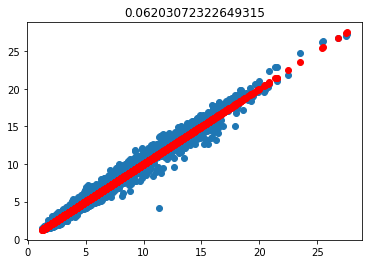

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


def cal_score(pred, real, absolute=False):
    pred = np.array(pred).copy()
    real = np.array(real).copy()
    if absolute: 
        return abs((pred-real)/real)
    else:
        return (pred-real)/real
    

x_train, x_test, y_train, y_test = train_test_split(scaler_dense_data, np.array(times_data_dense), test_size=0.1, random_state=0)
batch_model = keras.Sequential()
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(1, kernel_initializer='normal'))
batch_model.compile(loss='mean_squared_error', optimizer='adam')

history_batch = batch_model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_test, y_test), verbose=True)
batch_y_pred = batch_model.predict(x_test)
batch_y_pred = batch_y_pred.reshape(batch_y_pred.shape[0],)
plt.scatter(y_test, batch_y_pred)
plt.scatter(y_test, y_test, c='r')
plt.title(f'{np.mean(cal_score(y_test, batch_y_pred, True))}')
plt.savefig('flops_acc.png')
plt.show()


In [31]:
gnn = gen_nn(
    hidden_layers_num_lower=5,
    hidden_layers_num_upper=51, # only up to 51, influence train feature1
    hidden_layer_size_lower=1,
    hidden_layer_size_upper=1001, # only up to 1001, max we want to take
    activation='random',
    optimizer='random', # random
    loss='random'
)
model_configs = gnn.generate_model_configs(num_model_data=200)


100%|██████████| 200/200 [00:05<00:00, 35.51it/s]


In [32]:
def build_dense_model(layer_sizes, activations):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    model_dense = Sequential()
    for index, size in enumerate(layer_sizes):
        model_dense.add(Dense(size, activation=activations[index]))
    return model_dense

In [33]:
from sklearn.preprocessing import OneHotEncoder

optimizers =  ["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"]

unique_all_optimizers = sorted(list(set(optimizers)))
enc = OneHotEncoder(handle_unknown='ignore')
x_opts = [[i] for i in unique_all_optimizers]
enc.fit(x_opts)


OneHotEncoder(handle_unknown='ignore')

## get predictions

In [34]:
from tqdm import tqdm
import random
batch_sizes = random.choices([2**i for i in range(1, 9)], k=200)
epochs = 10
  
    
real_times = []
predicted_times = []
    
    
    
def get_units_sum_dense_keras(dense_model_obj):
    return sum([
        layer['config']['units'] for layer in dense_model_obj.get_config()['layers']
        if layer['class_name'] == 'Dense'
    ])

def convert_model_keras(
    input_shape, dense_model_obj, optimizer, batch_size, data_type='Unit', scaler=None
):
    unit_sum = get_units_sum_dense_keras(dense_model_obj)

    if data_type.lower().startswith('f'):
        layer_data = flops
    elif data_type.lower().startswith('u'):
        layer_data = unit_sum
    else:
        layer_data = unit_sum

    optimizer_onehot = list(enc.transform([[optimizer]]).toarray()[0])
    layer_data = [layer_data] + [batch_size] + optimizer_onehot

    if scaler is not None:
        scaled_data = scaler.transform(np.array([layer_data]))
        return scaled_data
    else:
        return layer_data


for idx, model_config in enumerate(tqdm(model_configs)):
    batch_size = batch_sizes[idx]

    layer_sizes = model_config['layer_sizes']
    activations = model_config['activations']
    optimizer = model_config['optimizer']
    loss = model_config['loss']

    dense = build_dense_model(layer_sizes, activations)
    dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # Train
    input_shape = dense.get_config()['layers'][0]['config']['units']
    out_shape = dense.get_config()['layers'][-1]['config']['units']
    x = np.ones((batch_size, input_shape), dtype=np.float32)
    y = np.ones((batch_size, out_shape), dtype=np.float32)

    dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    time_callback = TimeHistory()

    dense.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

    real_times.append(np.mean(time_callback.batch_times[1:])*1000)

    dense_train_data = convert_model_keras(input_shape, dense, optimizer, batch_size, data_type='Unit', scaler=scaler)
    dense_batch_y_pred = batch_model.predict(dense_train_data)[0][0]
    predicted_times.append(dense_batch_y_pred)

100%|██████████| 200/200 [07:05<00:00,  2.13s/it]


In [35]:
true_errors = cal_score(predicted_times, real_times, absolute=False)
np.mean(cal_score(predicted_times, real_times, absolute=True))

0.0835402464726938

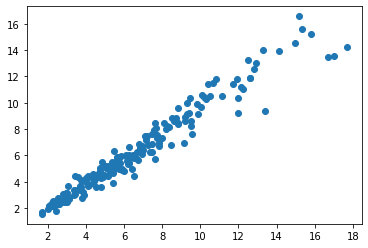

In [36]:
plt.scatter(real_times, predicted_times)

In [37]:

def objective_function(factor):
    factor = factor[0]
    def get_units_sum_dense_keras_factor(dense_model_obj):
        units = []
        for layer in dense_model_obj.get_config()['layers']:
            if layer['class_name'] == 'Dense':
                if layer['config']['trainable']:
                    units.append(layer['config']['units'])
                else:
                    units.append(np.ceil(factor * layer['config']['units']))
            else:
                pass
        return sum(units)
    
    def convert_model_keras_factor(
        input_shape, dense_model_obj, optimizer, batch_size, data_type='Unit', scaler=None
    ):
        unit_sum = get_units_sum_dense_keras_factor(dense_model_obj)

        if data_type.lower().startswith('f'):
            layer_data = flops
        elif data_type.lower().startswith('u'):
            layer_data = unit_sum
        else:
            layer_data = unit_sum

        optimizer_onehot = list(enc.transform([[optimizer]]).toarray()[0])
        layer_data = [layer_data] + [batch_size] + optimizer_onehot

        if scaler is not None:
            scaled_data = scaler.transform(np.array([layer_data]))
            return scaled_data
        else:
            return layer_data
        
    real_times = []
    predicted_times = []
    
    for idx, model_config in enumerate(tqdm(model_configs)):
        batch_size = batch_sizes[idx]

        layer_sizes = model_config['layer_sizes']
        activations = model_config['activations']
        optimizer = model_config['optimizer']
        loss = model_config['loss']
        num_layers = len(layer_sizes)
        
        top_n = random.sample(list(range(num_layers)), 1)[0]

        dense = build_dense_model(layer_sizes, activations)
        
        for layer in dense.layers[:top_n]:
            layer.trainable = False
        dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

        # Train
        input_shape = dense.get_config()['layers'][0]['config']['units']
        out_shape = dense.get_config()['layers'][-1]['config']['units']
        x = np.ones((batch_size, input_shape), dtype=np.float32)
        y = np.ones((batch_size, out_shape), dtype=np.float32)

        dense.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

        time_callback = TimeHistory()
        
        dense.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

        real_times.append(np.mean(time_callback.batch_times[1:])*1000)

        dense_train_data = convert_model_keras_factor(input_shape, dense, optimizer, batch_size, data_type='Unit', scaler=scaler)
        dense_batch_y_pred = batch_model.predict(dense_train_data)[0][0]
        predicted_times.append(dense_batch_y_pred)
    error = cal_score(predicted_times, real_times, absolute=False)
    obj_tar = np.linalg.norm(error-true_errors)
    print(factor, np.mean(error), np.mean(true_errors), obj_tar)
    return obj_tar



In [38]:
initial_value = [.2]
bounds = [(0, 1)]

from scipy.optimize import minimize

res = minimize(objective_function, initial_value, method='Powell', tol=1e-5, options={'maxiter': 10000}, bounds=bounds)

  0%|          | 0/200 [00:00<?, ?it/s]

0.2 -0.040418168914354825 -0.04818541124634284 1.77706641525439


  0%|          | 0/200 [00:00<?, ?it/s]

0.3819660112501051 0.06525349130602667 -0.04818541124634284 3.6266909466684782


  0%|          | 0/200 [00:00<?, ?it/s]

0.6180339887498948 0.20513403199890543 -0.04818541124634284 5.795882377423517


  0%|          | 0/200 [00:00<?, ?it/s]

0.2360679774997897 -0.032000713351905755 -0.04818541124634284 2.0447634916505875


  0%|          | 0/200 [00:00<?, ?it/s]

0.14589803375031546 -0.07443557925623845 -0.04818541124634284 1.8789092799784501


  0%|          | 0/200 [00:00<?, ?it/s]

0.1668690695622651 -0.07187589224995286 -0.04818541124634284 2.0418501001325806


  0%|          | 0/200 [00:00<?, ?it/s]

0.09016994374947426 -0.10900558832975041 -0.04818541124634284 2.1093270346016264


  0%|          | 0/200 [00:00<?, ?it/s]

0.12461179749810729 -0.08876471640715461 -0.04818541124634284 1.8914448396947616


  0%|          | 0/200 [00:00<?, ?it/s]

0.13674351276169228 -0.0723376044907023 -0.04818541124634284 1.9843477421879419


  0%|          | 0/200 [00:00<?, ?it/s]

0.15390825665118898 -0.05827181449325595 -0.04818541124634284 1.8731329435800605


  0%|          | 0/200 [00:00<?, ?it/s]

0.1588588466613916 -0.05676200189179121 -0.04818541124634284 2.0036882838594288


  0%|          | 0/200 [00:00<?, ?it/s]

0.15084862376051808 -0.07193998199335437 -0.04818541124634284 2.1153284120118827


  0%|          | 0/200 [00:00<?, ?it/s]

0.1557992137707207 -0.07241082906251116 -0.04818541124634284 1.896869742746125


  0%|          | 0/200 [00:00<?, ?it/s]

0.1527395808800498 -0.06246178593742721 -0.04818541124634284 1.9276934919484745


  0%|          | 0/200 [00:00<?, ?it/s]

0.15463053799958149 -0.07796044863571934 -0.04818541124634284 1.9509869204395565


  0%|          | 0/200 [00:00<?, ?it/s]

0.1534618622284423 -0.06731499766406293 -0.04818541124634284 1.771201377449807


  0%|          | 0/200 [00:00<?, ?it/s]

0.15318597530279648 -0.061950597723952824 -0.04818541124634284 2.0283054727598895


  0%|          | 0/200 [00:00<?, ?it/s]

0.15363236972554314 -0.06661113236855581 -0.04818541124634284 1.9208810276185329


  0%|          | 0/200 [00:00<?, ?it/s]

0.1533564827998973 -0.06115022303841757 -0.04818541124634284 1.9451259284107558


  0%|          | 0/200 [00:00<?, ?it/s]

0.15352699029699815 -0.0751602297143635 -0.04818541124634284 1.8633718557127947


  0%|          | 0/200 [00:00<?, ?it/s]

0.15342161086845316 -0.07382269769097777 -0.04818541124634284 2.0031041791567423


  0%|          | 0/200 [00:00<?, ?it/s]

0.153486738937009 -0.06616948083257004 -0.04818541124634284 1.9183784230003813


  0%|          | 0/200 [00:00<?, ?it/s]

0.15344648757701984 -0.07030242094523126 -0.04818541124634284 1.8899371123165258


  0%|          | 0/200 [00:00<?, ?it/s]

0.15347136428558655 -0.071129979578064 -0.04818541124634284 1.9694036601585305


  0%|          | 0/200 [00:00<?, ?it/s]

0.15345598963416412 -0.08595566482061144 -0.04818541124634284 1.923112449439259


  0%|          | 0/200 [00:00<?, ?it/s]

0.15346549169130835 -0.07569273536761821 -0.04818541124634284 1.8753866613611423


  0%|          | 0/200 [00:00<?, ?it/s]

0.10692372445688458 -0.08679828053154927 -0.04818541124634284 2.049938558608757


  0%|          | 0/200 [00:00<?, ?it/s]

0.3819660112501051 0.07158460616677814 -0.04818541124634284 3.305095225788546


  0%|          | 0/200 [00:00<?, ?it/s]

0.6180339887498948 0.2203864948010922 -0.04818541124634284 6.277424237647885


  0%|          | 0/200 [00:00<?, ?it/s]

0.2360679774997897 -0.02097155404870886 -0.04818541124634284 2.245419206485788


 70%|██████▉   | 139/200 [03:29<01:32,  1.51s/it]


KeyboardInterrupt: 

In [ ]:
0.14332425658528036

In [ ]:
0.1928287370353737

In [ ]:
0.184045506860147

In [ ]:
0.1534618622284423

# Try find some quick factor for estimation CNN

In [1]:
import os, json

all_training_data_file_conv2d = []

for dirpath, dirnames, filenames in os.walk("/home/jupyter/TrainDataCurrentCNN"):
    for filename in [f for f in filenames if f.endswith(".json") and int(f.split('_')[1])<9]:
        all_training_data_file_conv2d.append(os.path.join(dirpath, filename))

model_data_conv2d = []
for name in all_training_data_file_conv2d:
    with open(name, 'r') as fp:
        model_data_conv2d.extend(json.load(fp))

    

In [2]:
len(model_data_conv2d)

41300

In [3]:
from model_trainingtime_prediction.model_level_utils_cnn import convert_cnn2d_data, gen_cnn2d, TimeHistory

In [4]:

ccd = convert_cnn2d_data()

# Convert raw data into data points
scaler_conv_data, times_data_conv2d, scaler = ccd.convert_model_config(
    model_data_conv2d, layer_num_upper=105, data_type='FLOPs', min_max_scaler=True
)


100%|██████████| 41300/41300 [00:17<00:00, 2420.78it/s]


Epoch 1/30
2324/2324 [==============================] - 8s 3ms/step - loss: 55.8416 - val_loss: 42.0255
Epoch 2/30
2324/2324 [==============================] - 6s 3ms/step - loss: 28.4729 - val_loss: 31.8657
Epoch 3/30
2324/2324 [==============================] - 6s 3ms/step - loss: 25.3842 - val_loss: 32.9217
Epoch 4/30
2324/2324 [==============================] - 6s 3ms/step - loss: 20.6766 - val_loss: 29.5376
Epoch 5/30
2324/2324 [==============================] - 6s 3ms/step - loss: 18.8793 - val_loss: 26.0235
Epoch 6/30
2324/2324 [==============================] - 6s 3ms/step - loss: 18.0258 - val_loss: 21.5889
Epoch 7/30
2324/2324 [==============================] - 6s 3ms/step - loss: 16.8558 - val_loss: 21.9291
Epoch 8/30
2324/2324 [==============================] - 6s 3ms/step - loss: 15.9964 - val_loss: 22.3587
Epoch 9/30
2324/2324 [==============================] - 6s 3ms/step - loss: 14.6923 - val_loss: 24.2168
Epoch 10/30
2324/2324 [==============================] - 6s 3ms/

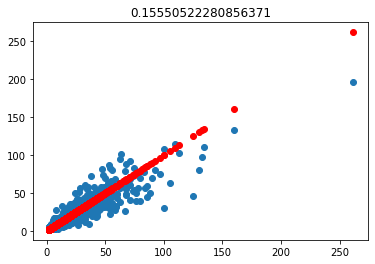

In [5]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tqdm import tqdm

def cal_score(pred, real, absolute=False):
    pred = np.array(pred).copy()
    real = np.array(real).copy()
    if absolute:
        return abs((pred - real) / real)
    else:
        return (pred - real) / real

# train data
x_train, x_test, y_train, y_test = train_test_split(
    scaler_conv_data, times_data_conv2d, test_size=0.1, random_state=0
)

batch_model = keras.Sequential()
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(200, kernel_initializer='normal', activation='relu'))
batch_model.add(Dense(1, kernel_initializer='normal'))
# Compile model
batch_model.compile(loss='mean_squared_error', optimizer='adam')

history_batch = batch_model.fit(
    x_train, y_train, batch_size=16, epochs=30, validation_data=(x_test, y_test), verbose=True
)
batch_y_pred = batch_model.predict(x_test)
batch_y_pred = batch_y_pred.reshape(batch_y_pred.shape[0], )
plt.scatter(y_test, batch_y_pred)
plt.scatter(y_test, y_test, c='r')
plt.title(f'{np.mean(cal_score(y_test, batch_y_pred, True))}')
plt.show()

In [6]:
gen = gen_cnn2d(
    input_shape_lower=8,
    input_shape_upper=29,
    conv_layer_num_lower=1,
    conv_layer_num_upper=51,
    filter_lower=1,
    filter_upper=101,
    dense_layer_num_lower=1,
    dense_layer_num_upper=6,
    dense_size_lower=1,
    dense_size_upper=1001,
    max_pooling_prob=.5,
    input_channels=None,
    paddings=None,
    activations=None,
    optimizers=None,
    losses=None
    )
model_configs = gen.generate_model_configs(num_model_data=100, progress=True)

100%|██████████| 100/100 [00:00<00:00, 450.29it/s]


In [7]:
def build_cnn2d_model(kwargs_list, layer_orders):
    cnn2d = Sequential()
    for i, lo in enumerate(layer_orders):
        kwargs = kwargs_list[i]
        if lo == "Dense":
            cnn2d.add(Dense(**kwargs))
        elif lo == "Conv2D":
            cnn2d.add(Conv2D(**kwargs))
        elif lo == "MaxPooling2D":
            cnn2d.add(MaxPooling2D(**kwargs))
        elif lo == "Dropout":
            cnn2d.add(Dropout(**kwargs))
        elif lo == "Flatten":
            cnn2d.add(Flatten())
    kwargs = kwargs_list[-1]
#     cnn2d.compile(metrics=['accuracy'], **kwargs["Compile"])
    return cnn2d

In [8]:
from sklearn.preprocessing import OneHotEncoder

optimizers =  ["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"]

unique_all_optimizers = sorted(list(set(optimizers)))
enc = OneHotEncoder(handle_unknown='ignore')
x_opts = [[i] for i in unique_all_optimizers]
enc.fit(x_opts)


OneHotEncoder(handle_unknown='ignore')

## get predictions

In [9]:
from collections.abc import Iterable

def conv2d_layer_flops(h, w, c, k, out):
    return h * w * (2 * c * k * k - 1) * out
def dense_layer_flops(i, o):
    return (2 * i - 1) * o
    
def get_flops_conv2d_keras(input_shape, conv_model_obj, sum_all=True, add_pooling=True, conv_factor=1, pooling_factor=1, dense_factor=0.178516):
    conv_flops = []
    pool_flops = []
    dense_flops = []
    all_flops = []
    for idx, layer_data in enumerate(conv_model_obj.get_config()['layers']):
        layer_name = layer_data['class_name']
        layer_config = layer_data['config']
        if layer_name == 'Conv2D' or layer_name == 'SeparableConv2D':
            filters = layer_config['filters']
            kernel_size = layer_config['kernel_size'][0]
            strides = layer_config['strides'][0]
            padding_method = layer_config['padding']
            previous_channels = input_shape[-1]
            if padding_method == 'same':
                output = convert_cnn2d_data.same_padding_output(
                    input_shape[0], kernel_size, strides
                )
                flops = convert_cnn2d_data.conv2d_layer_flops(
                    input_shape[0], input_shape[1], previous_channels, kernel_size, filters
                )
                conv_flops.append(conv_factor*flops)
                all_flops.append(conv_factor*flops)
                input_shape = [output, output, filters]
                # conv_flops.append(np.prod(input_shape))
            else:
                output = convert_cnn2d_data.valid_padding_output(
                    input_shape[0], kernel_size, strides
                )
                flops = convert_cnn2d_data.conv2d_layer_flops(
                    input_shape[0], input_shape[1], previous_channels, kernel_size, filters
                )
                conv_flops.append(conv_factor*flops)
                all_flops.append(conv_factor*flops)
                input_shape = [output, output, filters]
                # conv_flops.append(np.prod(input_shape))

        if layer_name == 'MaxPooling2D' or layer_name == 'AveragePooling2D':
            kernel_size = layer_config['pool_size'][0]
            strides = layer_config['strides'][0]
            padding_method = layer_config['padding']
            previous_channels = input_shape[-1]
            if padding_method == 'same':
                output = convert_cnn2d_data.same_padding_output(
                    input_shape[0], kernel_size, strides
                )
                flops = convert_cnn2d_data.conv2d_layer_flops(
                    input_shape[0], input_shape[1], previous_channels, kernel_size,
                    previous_channels
                )
                # flops = np.prod(input_shape)
                pool_flops.append(pooling_factor*flops)
                all_flops.append(pooling_factor*flops)
                input_shape = [output, output, previous_channels]
            else:
                output = convert_cnn2d_data.valid_padding_output(
                    input_shape[0], kernel_size, strides
                )
                flops = convert_cnn2d_data.conv2d_layer_flops(
                    input_shape[0], input_shape[1], previous_channels, kernel_size,
                    previous_channels
                )
                # flops = np.prod(input_shape)
                pool_flops.append(pooling_factor*flops)
                all_flops.append(pooling_factor*flops)
                input_shape = [output, output, previous_channels]

        if layer_name == 'ZeroPadding2D':
            w_padding_size = layer_config['padding'][0]
            h_padding_size = layer_config['padding'][1]
            input_shape = [
                input_shape[0] + np.sum(w_padding_size),
                input_shape[1] + np.sum(h_padding_size), input_shape[-1]
            ]
        if layer_name == 'Cropping2D':
            w_cropping_size = layer_config['cropping'][0]
            h_cropping_size = layer_config['cropping'][1]
            input_shape = [
                input_shape[0] - np.sum(w_cropping_size),
                input_shape[1] - np.sum(h_cropping_size), input_shape[-1]
            ]

        if layer_name == 'Dense':
            if isinstance(input_shape, Iterable):
                input_shape = np.prod(input_shape)
            else:
                pass
            flops = convert_cnn2d_data.dense_layer_flops(input_shape, layer_config['units'])
            input_shape = layer_config['units']
            dense_flops.append(dense_factor*flops)
            all_flops.append(dense_factor*flops)
            # dense_flops.append(input_shape)
    if sum_all:
        if add_pooling:
            return sum(all_flops)
        else:
            return sum(conv_flops + dense_flops)
    else:
        if add_pooling:
            return all_flops
        else:
            return conv_flops + dense_flops

In [10]:
def convert_model_keras_cnn(
    conv_model_obj,
    input_shape,
    optimizer,
    batch_size,
    layer_num_upper=105,
    data_type='FLOPs',
    scaler=None,
    conv_factor=1, pooling_factor=1, dense_factor=0.178516
):

    flops_layer = get_flops_conv2d_keras(input_shape, conv_model_obj, False, conv_factor=conv_factor, pooling_factor=pooling_factor, dense_factor=dense_factor)
    flops_layer = flops_layer[:layer_num_upper]
    short_position = layer_num_upper - len(flops_layer)
    flops_layer = flops_layer + [0] * short_position

    if data_type.lower().startswith('f'):
        layer_data = flops_layer.copy()
    else:
        layer_data = flops_layer.copy()

    optimizer_onehot = list(enc.transform([[optimizer]]).toarray()[0])
    layer_data = layer_data + [batch_size] + optimizer_onehot

    if scaler is not None:
        scaled_data = scaler.transform(np.array([layer_data]))
        return scaled_data
    else:
        return layer_data

In [11]:
from tqdm import tqdm
import random

batch_sizes = random.choices([2**i for i in range(1, 9)], k=200)
epochs = 10
  
    
real_times_cnn = []
predicted_times_cnn = []


for idx, model_config in enumerate(tqdm(model_configs)):
    batch_size = batch_sizes[idx]
    
    kwargs_list = model_config[0]
    layer_orders = model_config[1]
    input_shape = model_config[2]
    kwargs = kwargs_list[-1]
    optimizer = kwargs['Compile']['optimizer']
    
    conv2dmodel = build_cnn2d_model(kwargs_list, layer_orders)
    conv2dmodel.compile(metrics=['accuracy'], **kwargs["Compile"])
    
    out_shape = conv2dmodel.get_config()['layers'][-1]['config']['units']
    
    # Train
    x = np.ones((batch_size, *input_shape), dtype=np.float32)
    y = np.ones((batch_size, out_shape), dtype=np.float32)

    time_callback = TimeHistory()
    conv2dmodel.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

    real_times_cnn.append(np.mean(time_callback.batch_times[1:])*1000)    
    
    cnn_data = convert_model_keras_cnn(conv2dmodel,input_shape,optimizer,batch_size,layer_num_upper=105,data_type='FLOPs',scaler=scaler)
    
    cnn_batch_y_pred = batch_model.predict(cnn_data)[0][0]
    predicted_times_cnn.append(cnn_batch_y_pred)

100%|██████████| 100/100 [04:31<00:00,  2.71s/it]


In [12]:
true_errors = cal_score(predicted_times_cnn, real_times_cnn, absolute=False)
np.mean(cal_score(predicted_times_cnn, real_times_cnn, absolute=True))

0.14715997133535416

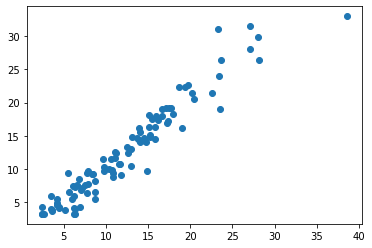

In [13]:
plt.scatter(real_times_cnn, predicted_times_cnn)

In [14]:
import random

def objective_function(factor):
    conv_factor = factor[0]
    pooling_factor = factor[1]
    
    real_times_cnn = []
    predicted_times_cnn = []
    
    for idx, model_config in enumerate(tqdm(model_configs)):
        batch_size = batch_sizes[idx]
        
        kwargs_list = model_config[0]
        layer_orders = model_config[1]
        input_shape = model_config[2]
        kwargs = kwargs_list[-1]
        optimizer = kwargs['Compile']['optimizer']
        num_layers = len(model_config[1])

        conv2dmodel = build_cnn2d_model(kwargs_list, layer_orders)
        
        top_n = random.sample(list(range(num_layers)), 1)[0]
        
        for layer in conv2dmodel.layers[:top_n]:
            layer.trainable = False
        
        conv2dmodel.compile(metrics=['accuracy'], **kwargs["Compile"])

        out_shape = conv2dmodel.get_config()['layers'][-1]['config']['units']

        # Train
        x = np.ones((batch_size, *input_shape), dtype=np.float32)
        y = np.ones((batch_size, out_shape), dtype=np.float32)

        time_callback = TimeHistory()
        conv2dmodel.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

        real_times_cnn.append(np.mean(time_callback.batch_times[1:])*1000)    

        cnn_data = convert_model_keras_cnn(conv2dmodel,input_shape,optimizer,batch_size,layer_num_upper=105,data_type='FLOPs',scaler=scaler,
                                          conv_factor=conv_factor, pooling_factor=pooling_factor)

        cnn_batch_y_pred = batch_model.predict(cnn_data)[0][0]
        predicted_times_cnn.append(cnn_batch_y_pred)
        
    error = cal_score(predicted_times_cnn, real_times_cnn, absolute=False)
    obj_tar = np.linalg.norm(error-true_errors)
    print(factor, np.mean(error), np.mean(true_errors), obj_tar)
    return obj_tar



In [15]:
initial_value = [.2, .2]
bounds = [(0, 1), (0, 1)]

from scipy.optimize import minimize

res = minimize(objective_function, initial_value, method='Powell', tol=1e-5, options={'maxiter': 10000}, bounds=bounds)

  0%|          | 0/100 [00:00<?, ?it/s]

[0.2 0.2] 0.3487704498452372 0.03595404543863159 4.884429457975912


  0%|          | 0/100 [00:00<?, ?it/s]

[0.38196601 0.2       ] 0.5500243101106759 0.03595404543863159 6.875028409189896


  0%|          | 0/100 [00:00<?, ?it/s]

[0.61803399 0.2       ] 0.5034463053224632 0.03595404543863159 6.256782398467304


  0%|          | 0/100 [00:00<?, ?it/s]

[0.76393202 0.2       ] 0.5089202157239052 0.03595404543863159 6.52519390617551


  0%|          | 0/100 [00:00<?, ?it/s]

[0.61217999 0.2       ] 0.4358789326009972 0.03595404543863159 6.465397299488707


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.2       ] 0.383510371911971 0.03595404543863159 5.2406912253504565


  0%|          | 0/100 [00:00<?, ?it/s]

[0.716545 0.2     ] 0.49246055055714033 0.03595404543863159 6.311893250884831


  0%|          | 0/100 [00:00<?, ?it/s]

[0.66675187 0.2       ] 0.43493002524567037 0.03595404543863159 5.50297587399899


  0%|          | 0/100 [00:00<?, ?it/s]

[0.69844477 0.2       ] 0.4681974425228349 0.03595404543863159 6.286801510789835


  0%|          | 0/100 [00:00<?, ?it/s]

[0.67942549 0.2       ] 0.5901111973056851 0.03595404543863159 7.029789503102529


  0%|          | 0/100 [00:00<?, ?it/s]

[0.69153109 0.2       ] 0.5814654290249291 0.03595404543863159 7.4701985445428


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68426637 0.2       ] 0.6707892257483477 0.03595404543863159 8.182718046140355


  0%|          | 0/100 [00:00<?, ?it/s]

[0.6888903 0.2      ] 0.5554600297226624 0.03595404543863159 6.783014963640769


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68611543 0.2       ] 0.6770702801827452 0.03595404543863159 7.923303978362442


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68788161 0.2       ] 0.7324667166892482 0.03595404543863159 9.393296835061408


  0%|          | 0/100 [00:00<?, ?it/s]

[0.6868217 0.2      ] 0.6236485844609521 0.03595404543863159 7.83909734384054


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68749633 0.2       ] 0.602298425149455 0.03595404543863159 7.838570312765964


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68709148 0.2       ] 0.5009282952367561 0.03595404543863159 5.98014127427682


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68734916 0.2       ] 0.634539018131613 0.03595404543863159 8.47526419778853


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68719452 0.2       ] 0.6509689221202858 0.03595404543863159 7.847435348631956


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68729295 0.2       ] 0.6504963166358069 0.03595404543863159 8.169820101617264


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68723388 0.2       ] 0.6651447282727461 0.03595404543863159 8.21107121159311


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68727148 0.2       ] 0.6048024212087725 0.03595404543863159 7.621913939579404


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68724892 0.2       ] 0.6090406780015083 0.03595404543863159 7.918877479720024


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68726328 0.2       ] 0.5786404135404131 0.03595404543863159 7.1256716191653755


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725466 0.2       ] 0.5278911851637038 0.03595404543863159 6.3751153349854235


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.38196601] 0.6284021814334513 0.03595404543863159 7.889059499457192


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61803399] 0.631628035683998 0.03595404543863159 7.285358659682889


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.76393202] 0.614136693953427 0.03595404543863159 7.839707169030866


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.57683082] 0.624960567207052 0.03595404543863159 7.841885195228631


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.67044435] 0.6458028294014884 0.03595404543863159 7.302150788606417


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.63805296] 0.6205045907043837 0.03595404543863159 7.803276737820688


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.60229578] 0.6701732599029261 0.03595404543863159 8.316208447100346


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.62568056] 0.6740127791418928 0.03595404543863159 7.989548778857368


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61202253] 0.6589679779701214 0.03595404543863159 8.480525112075254


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.62095472] 0.6920198655404534 0.03595404543863159 8.412773109063362


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61573781] 0.5716145832246016 0.03595404543863159 7.686618683824472


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61914961] 0.7348563476079264 0.03595404543863159 8.528923826568525


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61715693] 0.6744104334154098 0.03595404543863159 8.02095096704619


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61846012] 0.6375386411311512 0.03595404543863159 8.4110449706291


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61769898] 0.7039372291050761 0.03595404543863159 8.52905153595296


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61819676] 0.6175674905788644 0.03595404543863159 7.246332473076594


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61829735] 0.7125241437333166 0.03595404543863159 8.537778811356539


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61813458] 0.6698977034766728 0.03595404543863159 7.592743166294752


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61823518] 0.6886159032473175 0.03595404543863159 8.191717045159866


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61817301] 0.7003146105356552 0.03595404543863159 8.683838570764651


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61821143] 0.5695383896436882 0.03595404543863159 6.9483151865743755


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.6182205 ] 0.5485199171499641 0.03595404543863159 6.529478400941092


  0%|          | 0/100 [00:00<?, ?it/s]

[0.68725821 0.61822611] 0.6865340892176033 0.03595404543863159 8.028026923615174


100%|██████████| 100/100 [02:45<00:00,  1.65s/it]

[0.68725821 0.61821704] 0.7670777661298122 0.03595404543863159 9.076998613129806


# Bayesian

In [18]:
from xin_util.Optimization import Bayesian

In [19]:
import random


def objective_bayesian(**kwargs):
    factor_names = sorted(list(kwargs.keys()))
    factor = [kwargs[name] for name in factor_names]
    
    conv_factor = factor[0]
    pooling_factor = factor[1]
    
    real_times_cnn = []
    predicted_times_cnn = []
    
    for idx, model_config in enumerate(tqdm(model_configs)):
        batch_size = batch_sizes[idx]
        
        kwargs_list = model_config[0]
        layer_orders = model_config[1]
        input_shape = model_config[2]
        kwargs = kwargs_list[-1]
        optimizer = kwargs['Compile']['optimizer']
        num_layers = len(model_config[1])

        conv2dmodel = build_cnn2d_model(kwargs_list, layer_orders)
        
        top_n = random.sample(list(range(num_layers)), 1)[0]
        
        for layer in conv2dmodel.layers[:top_n]:
            layer.trainable = False
        
        conv2dmodel.compile(metrics=['accuracy'], **kwargs["Compile"])

        out_shape = conv2dmodel.get_config()['layers'][-1]['config']['units']

        # Train
        x = np.ones((batch_size, *input_shape), dtype=np.float32)
        y = np.ones((batch_size, out_shape), dtype=np.float32)

        time_callback = TimeHistory()
        conv2dmodel.fit(x,y,epochs=epochs,batch_size=batch_size,callbacks=[time_callback],verbose=False)

        real_times_cnn.append(np.mean(time_callback.batch_times[1:])*1000)    

        cnn_data = convert_model_keras_cnn(conv2dmodel,input_shape,optimizer,batch_size,layer_num_upper=105,data_type='FLOPs',scaler=scaler,
                                          conv_factor=conv_factor, pooling_factor=pooling_factor)

        cnn_batch_y_pred = batch_model.predict(cnn_data)[0][0]
        predicted_times_cnn.append(cnn_batch_y_pred)
        
    error = cal_score(predicted_times_cnn, real_times_cnn, absolute=False)
    obj_tar = np.linalg.norm(error-true_errors)
    print(factor, np.mean(error), np.mean(true_errors), obj_tar)
    return obj_tar




In [20]:
param_space = [[0, 1, 'conv factor'], [0, 1, 'pooling factor']]


tuning = Bayesian(objective_callable=objective_bayesian, param_space=param_space)
result, bayesian_callback = tuning.train(n_calls=100, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.11967564611702045, 0.7243431471237586] 0.5416716389226931 0.05863766664803352 6.803170238496701
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 181.6865
Function value obtained: 6.8032
Current minimum: 6.8032
Iteration No: 2 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.6505490884175067, 0.5557256234438012] 0.5929692732948244 0.05863766664803352 7.083948038336875
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 179.6875
Function value obtained: 7.0839
Current minimum: 6.8032
Iteration No: 3 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.6991563215123661, 0.9355336097969501] 0.6137952837395804 0.05863766664803352 7.409283766941636
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 195.3144
Function value obtained: 7.4093
Current minimum: 6.8032
Iteration No: 4 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.7777969646281729, 0.48757760147011986] 0.6158527262286938 0.05863766664803352 7.763724193559743
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 185.1692
Function value obtained: 7.7637
Current minimum: 6.8032
Iteration No: 5 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.8787343800625178, 0.18356720117397687] 0.5801374304010125 0.05863766664803352 7.279925844150558
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 191.9459
Function value obtained: 7.2799
Current minimum: 6.8032
Iteration No: 6 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.5474809163683878, 0.656375040069424] 0.6781222613584218 0.05863766664803352 8.109677895818775
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 179.7648
Function value obtained: 8.1097
Current minimum: 6.8032
Iteration No: 7 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.9992210351558006, 0.2764125956449682] 0.6511529908323271 0.05863766664803352 7.669446833330268
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 185.7510
Function value obtained: 7.6694
Current minimum: 6.8032
Iteration No: 8 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.817778170951736, 0.20257901874766776] 0.6155098383569377 0.05863766664803352 7.733442472991594
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 178.5874
Function value obtained: 7.7334
Current minimum: 6.8032
Iteration No: 9 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.8085102041439578, 0.46869246640723605] 0.8243514720147093 0.05863766664803352 10.168317247033553
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 160.2946
Function value obtained: 10.1683
Current minimum: 6.8032
Iteration No: 10 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.42077624530815194, 0.6168199082847398] 0.6404261406136352 0.05863766664803352 7.566160171352629
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 180.2474
Function value obtained: 7.5662
Current minimum: 6.8032
Iteration No: 11 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.9569628957900099, 0.6441251101974055] 0.844881967612881 0.05863766664803352 9.967500523378169
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 169.3350
Function value obtained: 9.9675
Current minimum: 6.8032
Iteration No: 12 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.9260921409608954, 0.1899941872494883] 0.7439849964204893 0.05863766664803352 9.027897169976772
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 169.8712
Function value obtained: 9.0279
Current minimum: 6.8032
Iteration No: 13 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.20195956783209096, 0.1439653747362352] 0.4601191006909019 0.05863766664803352 6.347239979986585
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 174.7361
Function value obtained: 6.3472
Current minimum: 6.3472
Iteration No: 14 started. Evaluating function at random point.


  0%|          | 0/100 [00:00<?, ?it/s]

[0.6639293335402587, 0.30054921480505264] 0.6582900085373693 0.05863766664803352 8.038985882382338
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 178.0686
Function value obtained: 8.0390
Current minimum: 6.3472
Iteration No: 15 started. Evaluating function at random point.


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


[0.5164459614232102, 0.48460853490540723] 0.5264589783317694 0.05863766664803352 6.312203050383579


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 187.7364
Function value obtained: 6.3122
Current minimum: 6.3122
Iteration No: 16 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


[0.0, 0.08083827402292953] 0.22577905855044159 0.05863766664803352 5.497605322776649


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 180.4613
Function value obtained: 5.4976
Current minimum: 5.4976
Iteration No: 17 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


[0.0, 0.08754400919602004] 0.19057060817097982 0.05863766664803352 4.676246214460379


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 180.7883
Function value obtained: 4.6762
Current minimum: 4.6762
Iteration No: 18 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


[0.0, 0.0] 0.1887237377942264 0.05863766664803352 5.191476030085505


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 166.0988
Function value obtained: 5.1915
Current minimum: 4.6762
Iteration No: 19 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]


[0.0, 0.0] 0.13874305104382428 0.05863766664803352 5.0856328308392404


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 186.6401
Function value obtained: 5.0856
Current minimum: 4.6762
Iteration No: 20 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


[0.0, 0.0] 0.14381167395992944 0.05863766664803352 5.132342763992673


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 183.0291
Function value obtained: 5.1323
Current minimum: 4.6762
Iteration No: 21 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


[7.93946776876814e-09, 0.08886285500939362] 0.1759302822502766 0.05863766664803352 4.728645389114774


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 184.3737
Function value obtained: 4.7286
Current minimum: 4.6762
Iteration No: 22 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


[0.018322962217813876, 0.08826543515473331] 0.22978993799821937 0.05863766664803352 4.9700331903578485


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 174.5448
Function value obtained: 4.9700
Current minimum: 4.6762
Iteration No: 23 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


[0.05716726429636047, 0.0] 0.20527157487238515 0.05863766664803352 5.472891074882573


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 176.8274
Function value obtained: 5.4729
Current minimum: 4.6762
Iteration No: 24 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


[0.0, 0.01007615775614042] 0.17354805954718652 0.05863766664803352 4.970726440922869


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 177.0319
Function value obtained: 4.9707
Current minimum: 4.6762
Iteration No: 25 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


[0.0, 0.022941186160030082] 0.2028435319126884 0.05863766664803352 5.388489277758049


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 178.7039
Function value obtained: 5.3885
Current minimum: 4.6762
Iteration No: 26 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


[0.07009885274241419, 0.01491972170514808] 0.23256678210099047 0.05863766664803352 5.20379945765222


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 178.9501
Function value obtained: 5.2038
Current minimum: 4.6762
Iteration No: 27 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


[0.0, 0.09071840587709766] 0.22388638139675987 0.05863766664803352 5.515244388549793


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 175.7737
Function value obtained: 5.5152
Current minimum: 4.6762
Iteration No: 28 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


[0.0, 0.29783414169658967] 0.3140739263519018 0.05863766664803352 5.427711959068148


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 174.3782
Function value obtained: 5.4277
Current minimum: 4.6762
Iteration No: 29 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


[0.0, 0.0] 0.17387951620329267 0.05863766664803352 4.94849878347582


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 178.0085
Function value obtained: 4.9485
Current minimum: 4.6762
Iteration No: 30 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


[0.0, 1.0] 0.6395284770772464 0.05863766664803352 7.966954732776732


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 174.3817
Function value obtained: 7.9670
Current minimum: 4.6762
Iteration No: 31 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


[0.0, 0.25284389382121436] 0.29582506327501873 0.05863766664803352 5.084883119301811


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 174.6818
Function value obtained: 5.0849
Current minimum: 4.6762
Iteration No: 32 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


[0.0, 0.25260163147827863] 0.286545717084498 0.05863766664803352 5.245628376226707


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 178.7238
Function value obtained: 5.2456
Current minimum: 4.6762
Iteration No: 33 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


[0.3076691415030379, 0.0] 0.4287566460978368 0.05863766664803352 5.987572454553389


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 175.2034
Function value obtained: 5.9876
Current minimum: 4.6762
Iteration No: 34 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


[0.0, 0.0] 0.1881031394187604 0.05863766664803352 5.4647499367232975


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 174.8536
Function value obtained: 5.4647
Current minimum: 4.6762
Iteration No: 35 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


[0.0, 0.2714241799866491] 0.2518338663431899 0.05863766664803352 4.812751764558998


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 190.7330
Function value obtained: 4.8128
Current minimum: 4.6762
Iteration No: 36 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


[0.0, 0.2745422790461936] 0.30335788932769964 0.05863766664803352 5.476847394287548


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 180.3008
Function value obtained: 5.4768
Current minimum: 4.6762
Iteration No: 37 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


[0.0, 0.2748541429544132] 0.2723459042808612 0.05863766664803352 4.742964102864479


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 183.5515
Function value obtained: 4.7430
Current minimum: 4.6762
Iteration No: 38 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


[0.0, 0.32119878156214277] 0.3658110602918285 0.05863766664803352 5.859682765724261


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 173.1866
Function value obtained: 5.8597
Current minimum: 4.6762
Iteration No: 39 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


[0.0, 0.0] 0.1482502195198106 0.05863766664803352 5.027268105781057


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 180.3757
Function value obtained: 5.0273
Current minimum: 4.6762
Iteration No: 40 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


[0.0, 0.0] 0.13394950803634834 0.05863766664803352 4.973615869221882


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 184.3276
Function value obtained: 4.9736
Current minimum: 4.6762
Iteration No: 41 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


[0.0, 0.0] 0.14987775707103723 0.05863766664803352 5.041706728408458


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 178.2758
Function value obtained: 5.0417
Current minimum: 4.6762
Iteration No: 42 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


[0.0, 0.0] 0.13317075102497042 0.05863766664803352 5.257061625490151


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 183.8116
Function value obtained: 5.2571
Current minimum: 4.6762
Iteration No: 43 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


[0.0, 0.140669124832186] 0.2152242412599753 0.05863766664803352 5.089562199038182


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 190.4339
Function value obtained: 5.0896
Current minimum: 4.6762
Iteration No: 44 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


[0.0, 0.13932277471761073] 0.24415647427827872 0.05863766664803352 5.029375670727335


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 181.9582
Function value obtained: 5.0294
Current minimum: 4.6762
Iteration No: 45 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


[0.0, 0.13898535267543952] 0.27115989210558405 0.05863766664803352 5.881526415137827


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 168.9554
Function value obtained: 5.8815
Current minimum: 4.6762
Iteration No: 46 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


[0.0, 0.0] 0.16837354136380508 0.05863766664803352 4.907873137948801


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 174.2555
Function value obtained: 4.9079
Current minimum: 4.6762
Iteration No: 47 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


[0.0, 0.0] 0.11447327690547499 0.05863766664803352 4.90487497069519


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 188.2658
Function value obtained: 4.9049
Current minimum: 4.6762
Iteration No: 48 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


[0.0, 0.0] 0.2519451670078606 0.05863766664803352 6.203470686934084


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 167.2776
Function value obtained: 6.2035
Current minimum: 4.6762
Iteration No: 49 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:58<00:00,  1.79s/it]


[0.0, 0.0] 0.16336234194802088 0.05863766664803352 4.8635447300939605


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 179.5657
Function value obtained: 4.8635
Current minimum: 4.6762
Iteration No: 50 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


[0.0, 0.0] 0.15759842657146905 0.05863766664803352 5.16781828742189


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 186.8320
Function value obtained: 5.1678
Current minimum: 4.6762
Iteration No: 51 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


[0.0, 0.0] 0.14321122630678446 0.05863766664803352 5.161011576414044


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 176.8212
Function value obtained: 5.1610
Current minimum: 4.6762
Iteration No: 52 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


[0.0, 0.1461313919423976] 0.2983866627628775 0.05863766664803352 5.496672534481882


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 177.0752
Function value obtained: 5.4967
Current minimum: 4.6762
Iteration No: 53 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.84s/it]


[0.0, 0.0] 0.1639469486961188 0.05863766664803352 5.557466694934821


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 184.6790
Function value obtained: 5.5575
Current minimum: 4.6762
Iteration No: 54 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


[0.0, 0.14901679287347164] 0.2742896211210104 0.05863766664803352 5.551350983959467


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 174.0382
Function value obtained: 5.5514
Current minimum: 4.6762
Iteration No: 55 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


[0.0, 0.0] 0.1148355367356632 0.05863766664803352 4.908775403672675


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 191.9420
Function value obtained: 4.9088
Current minimum: 4.6762
Iteration No: 56 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


[0.0, 0.0] 0.12785855777350713 0.05863766664803352 4.603860143637878


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 186.1369
Function value obtained: 4.6039
Current minimum: 4.6039
Iteration No: 57 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


[0.0, 0.0] 0.1269561692040325 0.05863766664803352 5.0153833933072605


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 182.3106
Function value obtained: 5.0154
Current minimum: 4.6039
Iteration No: 58 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


[0.0, 0.0] 0.16235970540730335 0.05863766664803352 5.190474972034964


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 177.8217
Function value obtained: 5.1905
Current minimum: 4.6039
Iteration No: 59 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


[0.0, 0.0] 0.16787498070590767 0.05863766664803352 5.346506438822768


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 181.5182
Function value obtained: 5.3465
Current minimum: 4.6039
Iteration No: 60 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


[0.0, 0.0] 0.23049631827141093 0.05863766664803352 5.91829665370852


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 173.4602
Function value obtained: 5.9183
Current minimum: 4.6039
Iteration No: 61 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


[0.0, 0.1431597365948247] 0.1758295084812663 0.05863766664803352 4.122574444853478


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 178.5690
Function value obtained: 4.1226
Current minimum: 4.1226
Iteration No: 62 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


[0.0, 0.15832517762514056] 0.2635885807554938 0.05863766664803352 5.358563448587462


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 175.0287
Function value obtained: 5.3586
Current minimum: 4.1226
Iteration No: 63 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:59<00:00,  1.79s/it]


[0.0, 0.15306316792062521] 0.29426949368116917 0.05863766664803352 5.605719948110825


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 180.3565
Function value obtained: 5.6057
Current minimum: 4.1226
Iteration No: 64 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


[0.0, 0.14322899068115255] 0.22146191418227842 0.05863766664803352 5.2855216739345


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 181.6548
Function value obtained: 5.2855
Current minimum: 4.1226
Iteration No: 65 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


[0.0, 0.0] 0.20758872894568847 0.05863766664803352 5.594358881328691


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 171.7310
Function value obtained: 5.5944
Current minimum: 4.1226
Iteration No: 66 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


[0.0, 0.149743323031554] 0.25715839479796043 0.05863766664803352 4.8727966474079345


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 180.8838
Function value obtained: 4.8728
Current minimum: 4.1226
Iteration No: 67 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:00<00:00,  1.81s/it]


[0.0, 0.15294488056135339] 0.2751199062966496 0.05863766664803352 5.546155579945521


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 181.6532
Function value obtained: 5.5462
Current minimum: 4.1226
Iteration No: 68 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


[0.0, 0.14391150376708203] 0.20457913569272462 0.05863766664803352 5.146690705018547


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 180.6099
Function value obtained: 5.1467
Current minimum: 4.1226
Iteration No: 69 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


[0.0, 0.0] 0.16579596659581497 0.05863766664803352 5.524774662118696


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 175.9369
Function value obtained: 5.5248
Current minimum: 4.1226
Iteration No: 70 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


[0.0, 0.15175190093303997] 0.2549745236543723 0.05863766664803352 5.525041527354356


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 182.4475
Function value obtained: 5.5250
Current minimum: 4.1226
Iteration No: 71 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


[0.0, 0.0] 0.14905410870499336 0.05863766664803352 5.146390900627443


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 177.8552
Function value obtained: 5.1464
Current minimum: 4.1226
Iteration No: 72 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


[0.0, 0.1415003134127658] 0.2283609642441136 0.05863766664803352 4.834024906022636


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 182.8228
Function value obtained: 4.8340
Current minimum: 4.1226
Iteration No: 73 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


[0.0, 0.14591072407596373] 0.23855084919707426 0.05863766664803352 5.3630146365138


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 184.1697
Function value obtained: 5.3630
Current minimum: 4.1226
Iteration No: 74 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


[0.0, 0.1404878594835196] 0.30408012220293884 0.05863766664803352 6.123245435807212


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 167.5587
Function value obtained: 6.1232
Current minimum: 4.1226
Iteration No: 75 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


[0.0, 0.0] 0.1311304945789951 0.05863766664803352 4.843630679751498


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 184.2339
Function value obtained: 4.8436
Current minimum: 4.1226
Iteration No: 76 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.77s/it]


[0.0, 0.0] 0.18641360514157654 0.05863766664803352 5.156845397812162


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 177.9290
Function value obtained: 5.1568
Current minimum: 4.1226
Iteration No: 77 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


[0.0, 0.0] 0.10799441726653447 0.05863766664803352 4.727025043236526


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


[0.0, 0.0] 0.1863827776317961 0.05863766664803352 5.292509811885576


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 174.6556
Function value obtained: 5.2925
Current minimum: 4.1226
Iteration No: 79 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:49<00:00,  1.70s/it]


[0.0, 0.0] 0.22664489746288385 0.05863766664803352 5.912375262856998


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 171.1588
Function value obtained: 5.9124
Current minimum: 4.1226
Iteration No: 80 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


[0.0, 0.0] 0.21842622427547917 0.05863766664803352 5.983182888398196


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 175.6314
Function value obtained: 5.9832
Current minimum: 4.1226
Iteration No: 81 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


[0.0, 0.15086536969806175] 0.2809215964314792 0.05863766664803352 5.66721332411827


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 172.8984
Function value obtained: 5.6672
Current minimum: 4.1226
Iteration No: 82 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


[0.0, 0.0] 0.156543348187002 0.05863766664803352 4.91317148501247


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 189.3615
Function value obtained: 4.9132
Current minimum: 4.1226
Iteration No: 83 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


[0.0, 0.0] 0.12391555529418002 0.05863766664803352 4.970712382342312


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 189.3633
Function value obtained: 4.9707
Current minimum: 4.1226
Iteration No: 84 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


[0.0, 0.0] 0.10613951479610043 0.05863766664803352 4.414367600718059


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 183.5483
Function value obtained: 4.4144
Current minimum: 4.1226
Iteration No: 85 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


[0.0, 0.0] 0.18731193634725382 0.05863766664803352 5.537411238475405


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 181.5107
Function value obtained: 5.5374
Current minimum: 4.1226
Iteration No: 86 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]


[0.0, 0.0] 0.21532495211496258 0.05863766664803352 5.7895596826448505


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 174.0078
Function value obtained: 5.7896
Current minimum: 4.1226
Iteration No: 87 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


[0.0, 0.0] 0.17120032021817688 0.05863766664803352 5.582197593236726


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 174.8982
Function value obtained: 5.5822
Current minimum: 4.1226
Iteration No: 88 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


[0.0, 0.0] 0.1681049836734962 0.05863766664803352 4.993198406530187


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 177.5432
Function value obtained: 4.9932
Current minimum: 4.1226
Iteration No: 89 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


[0.0, 0.0] 0.12978496785355775 0.05863766664803352 5.089275948817463


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 186.1514
Function value obtained: 5.0893
Current minimum: 4.1226
Iteration No: 90 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


[0.0, 0.0] 0.17933310526140345 0.05863766664803352 5.460699459292502


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 174.5062
Function value obtained: 5.4607
Current minimum: 4.1226
Iteration No: 91 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


[0.0, 0.0] 0.16920326539863798 0.05863766664803352 5.213331550057944


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 175.0819
Function value obtained: 5.2133
Current minimum: 4.1226
Iteration No: 92 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:02<00:00,  1.83s/it]


[0.0, 0.0] 0.15979152990530504 0.05863766664803352 5.135706871093934


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 184.4012
Function value obtained: 5.1357
Current minimum: 4.1226
Iteration No: 93 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:03<00:00,  1.83s/it]


[0.08099592712896482, 0.0] 0.1819082566449307 0.05863766664803352 4.577156930618449


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 184.7159
Function value obtained: 4.5772
Current minimum: 4.1226
Iteration No: 94 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


[0.10451762056763286, 0.0] 0.25229000121518347 0.05863766664803352 5.042818739898527


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 175.3695
Function value obtained: 5.0428
Current minimum: 4.1226
Iteration No: 95 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


[0.10778379856203814, 0.0] 0.3048711636531269 0.05863766664803352 5.944302166373236


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 172.9512
Function value obtained: 5.9443
Current minimum: 4.1226
Iteration No: 96 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


[0.0, 0.0] 0.18345051481449132 0.05863766664803352 5.673231157061973


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 181.7671
Function value obtained: 5.6732
Current minimum: 4.1226
Iteration No: 97 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


[0.0, 0.12990629035649956] 0.22545017732551056 0.05863766664803352 5.204308271959032


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 177.9025
Function value obtained: 5.2043
Current minimum: 4.1226
Iteration No: 98 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:04<00:00,  1.84s/it]


[0.0, 0.12850732213380497] 0.21730604822799837 0.05863766664803352 5.160267396724817


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 185.6655
Function value obtained: 5.1603
Current minimum: 4.1226
Iteration No: 99 started. Searching for the next optimal point.


100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


[0.0, 0.0] 0.07619565098599755 0.05863766664803352 4.567191595282954


/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
  0%|          | 0/100 [00:00<?, ?it/s]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 186.7777
Function value obtained: 4.5672
Current minimum: 4.1226
Iteration No: 100 started. Searching for the next optimal point.


100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


[0.0, 0.0] 0.18399462698138533 0.05863766664803352 5.227564584246132
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 175.7216
Function value obtained: 5.2276
Current minimum: 4.1226


In [24]:
result['x']

[0.0, 0.1431597365948247]